Deep Learning Mini Project 2024
Vishwa Gopalakrishnan, Aditya Krishna, Ohm Patel
vg2507

In [1]:
# !pip install kaggle
# !kaggle competitions download -c deep-learning-mini-project-spring-24-nyu

Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import wandb
import pprint
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cuda


Code for loading batches from the dataset on kaggle and displaying some

<class 'dict'>
Batch 1


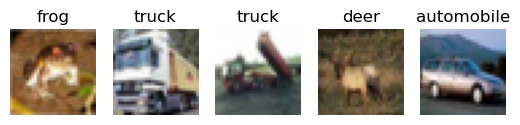

Batch 2


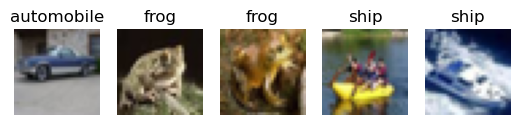

Batch 3


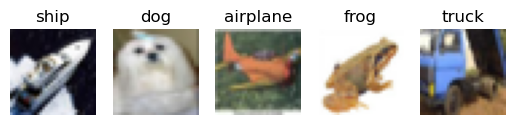

Batch 4


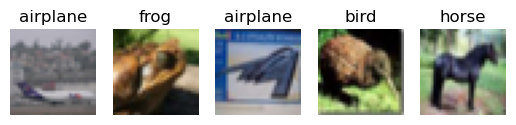

Batch 5


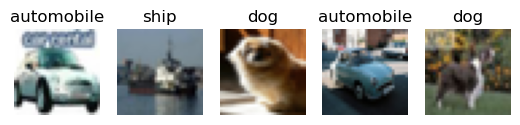

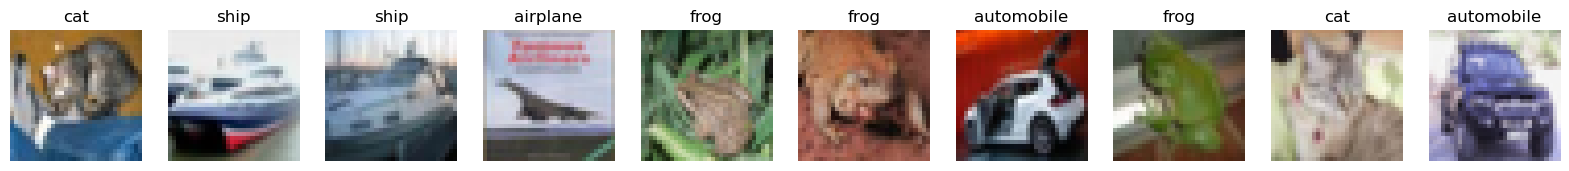

In [3]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/scratch/vg2507/DL/Mini Project/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'
batch_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

batches = [load_cifar_batch(os.path.join(cifar10_dir,file)) for file in batch_files]
print(type(batches[0]))

for i, batch in enumerate(batches):
    print(f"Batch {i+1}")
    data = batch[b'data']
    labels = batch[b'labels']
    
    for j in range(5):  # Display 5 images from each batch
        img = data[j].reshape(3, 32, 32).transpose(1, 2, 0)
        label = labels[j]
        class_name = label_names[label].decode('utf-8')
        
        plt.subplot(1, 5, j+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

# Load test batch
batch_test_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))

test_images=batch_test_dict[b'data']
test_labels=batch_test_dict[b'labels']
test_images = test_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i])
    plt.title(label_names[test_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

Creating the dataset for the batches in kaggle

In [4]:
class CIFARDataset(Dataset):
    def __init__(self, cifar10_dir, batch_files, mode='train', transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        # Load all batches
        if mode == 'train':
            for file_name in batch_files:
                file_path = os.path.join(cifar10_dir, file_name)
                with open(file_path, 'rb') as file:
                    batch = pickle.load(file, encoding='bytes')
                    self.data.append(batch[b'data'])
                    self.labels.extend(batch[b'labels'])
            self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        else:
            file_path = os.path.join(cifar10_dir, 'test_batch')
            with open(file_path, 'rb') as file:
                batch = pickle.load(file, encoding='bytes')
                self.data = batch[b'data'].reshape(-1, 3, 32, 32)
                self.labels = batch[b'labels']

        self.data = self.data.transpose((0, 2, 3, 1))  # Convert to HWC format for transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx], self.labels[idx]
        if self.transform:
            img = self.transform(img)

        return img, label


Resnet Block Class

In [5]:
class Block(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.0):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SEBlock(planes) 

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = nn.ReLU(inplace=True)(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = nn.ReLU(inplace=True)(out)
        return out

Main ResNetTrainer Class used for all operations. it has functions to create the network, prepare data, train and validate the network and also to save the model with the best accuracy.

In [6]:
class ResNetTrainer:
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.0):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.model = self.build_model(block, num_blocks, num_classes, dropout_rate)
        self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = None
        self.scheduler = None
        self.train_loader = None
        self.test_loader = None
        self.best_acc = 0

    def build_model(self, block, num_blocks, num_classes, dropout_rate):
        class ResNet(nn.Module):
            def __init__(self):
                super(ResNet, self).__init__()
                self.in_planes = 16

                self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
                self.bn1 = nn.BatchNorm2d(16)
                self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_rate=dropout_rate)
                self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout_rate=dropout_rate)
                self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, dropout_rate=dropout_rate)
                # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, dropout_rate=dropout_rate)
                self.linear = nn.Linear(256 * block.expansion, num_classes)

            def _make_layer(self, block, planes, num_blocks, stride, dropout_rate):
                strides = [stride] + [1] * (num_blocks - 1)
                layers = []
                for stride in strides:
                    layers.append(block(self.in_planes, planes, stride, dropout_rate))
                    self.in_planes = planes * block.expansion
                return nn.Sequential(*layers)

            def forward(self, x):
                out = nn.ReLU(inplace=True)(self.bn1(self.conv1(x)))
                out = self.layer1(out)
                out = self.layer2(out)
                out = self.layer3(out)
                # out = self.layer4(out)
                out = nn.AdaptiveAvgPool2d((1, 1))(out)
                out = torch.flatten(out, 1)
                out = self.linear(out)
                return out

        return ResNet()

    def set_hyperparameters(self, optimizer='Adam', lr=0.001, step_size=30, gamma=0.1):
        if optimizer == 'Adam':
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        elif optimizer == 'SGD':
            self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        elif optimizer == 'Adadelta':
             self.optimizer = optim.Adadelta(self.model.parameters(), lr=lr, weight_decay=0.0005)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)
    
    def prepare_data(self, batch_size=128):
        # Define transforms
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), inplace=True),
        ])
        
        # Paths and batch files
        cifar10_dir = '/scratch/vg2507/DL/Mini Project/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'
        batch_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
        
        # Creating datasets
        trainset = CIFARDataset(cifar10_dir, batch_files, 'train', transform=transform)
        testset = CIFARDataset(cifar10_dir, None, 'test', transform=transform)

        # trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        # testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        
        self.train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    def train(self, epochs=10):
        final_val_accuracy = 0
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            # Training loop
            for i, data in enumerate(self.train_loader, 0):
                inputs, labels = data[0].to(self.device), data[1].to(self.device)
                self.optimizer.zero_grad()
    
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
    
                train_loss += loss.item()
    
                if i % 200 == 199:  # print every 200 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, train_loss / 200))
                    train_loss = 0.0

            self.model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for data in self.test_loader: 
                    inputs, labels = data[0].to(self.device), data[1].to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
    
            val_accuracy = 100 * correct / total
            if val_accuracy > self.best_acc:
                print('Saving..')
                state = {
                    'net': self.model.state_dict(),
                    'acc': val_accuracy,
                    'epoch': epoch,
                }
                if not os.path.isdir('checkpoint'):
                    os.mkdir('checkpoint')
                torch.save(state, './checkpoint/ckptnnadadelta.pth')
        
                self.best_acc = val_accuracy
            
            final_val_accuracy = self.best_acc
            
            print('Validation Loss: %.3f, Validation Accuracy: %.2f%%' %
                  (val_loss / len(self.test_loader), val_accuracy))
    
            # Logging to wandb
            wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss / len(self.test_loader), "val_accuracy": val_accuracy})
    
            self.scheduler.step()
        print('Finished Training')
        print('Final Validation Accuracy: %.2f%%' % self.best_acc)

        # Log the final validation accuracy to wandb
        wandb.log({"final_val_accuracy": self.best_acc})

    
    def print_trainable_params(self):
        total_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        summary(self.model, (3, 32, 32))
        print(f'Total trainable parameters: {total_params}')

In [7]:
trainer = ResNetTrainer(Block, [4, 5, 3], dropout_rate=0)
trainer.print_trainable_params()

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 64, 32, 32]           9,216
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8           [-1, 64, 32, 32]           1,024
       BatchNorm2d-9           [-1, 64, 32, 32]             128
            Block-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
          Dropout-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1

In [ ]:
WandB setup and define the sweep parameters. Here we are just using one value for each parameter, so it is just like a single run.

In [8]:
!wandb login 

#wandb setup

sweep_config = {
    'method': 'random',   
}

parameters_dict = {
    'learning_rate': {
        'values': [1]
      },
    'optimizer': {
        'values': ['Adadelta']
        },
    'epochs': {
        'values': [100]
    },
    'dropout': {
        'values': [0]
    },
    'batch_size': {
        'values': [72]
      }
}

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)
sweep_id = wandb.sweep(sweep_config, project="dl-mini-project-with-kaggle-nn-adadelta")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/vg2507/.netrc
{'method': 'random',
 'parameters': {'batch_size': {'values': [72]},
                'dropout': {'values': [0]},
                'epochs': {'values': [100]},
                'learning_rate': {'values': [1]},
                'optimizer': {'values': ['Adadelta']}}}


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: afhnzwll
Sweep URL: https://wandb.ai/team9449/dl-mini-project-with-kaggle-nn-adadelta/sweeps/afhnzwll


Run the sweep

In [9]:
def sweepFunction(config=None):
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        trainer = ResNetTrainer(Block, [4, 5, 3], dropout_rate=config.dropout)
        trainer.set_hyperparameters(optimizer=config.optimizer, lr=config.learning_rate)
        trainer.prepare_data(batch_size=config.batch_size)
        trainer.print_trainable_params()
        trainer.train(epochs=config.epochs)

wandb.agent(sweep_id, sweepFunction, count=1)

wandb: Agent Starting Run: 79kipjxq with config:
wandb: 	batch_size: 72
wandb: 	dropout: 0
wandb: 	epochs: 100
wandb: 	learning_rate: 1
wandb: 	optimizer: Adadelta
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vishgoki (team9449). Use `wandb login --relogin` to force relogin


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 64, 32, 32]           9,216
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8           [-1, 64, 32, 32]           1,024
       BatchNorm2d-9           [-1, 64, 32, 32]             128
            Block-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
          Dropout-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_val_accuracy,▁
train_loss,█▅▄▄▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▅▆▆▇▆▆▆▆████████████████████████████
val_loss,█▅▃▃▄▃▃▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
final_val_accuracy,94.59
train_loss,0.3953
val_accuracy,94.29
val_loss,0.20875


Recorded best Validation Accuracy of 94.59

Load model weights from the best accuracy one which we saved earlier

In [14]:
checkpoint_path = './checkpoint/ckptnnadadelta.pth'
if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"No checkpoint found at '{checkpoint_path}'")

# Load the saved checkpoint
checkpoint = torch.load(checkpoint_path)

# Initialize the model
# model = MyModel()

trainer = ResNetTrainer(Block, [4, 5, 3], dropout_rate=0)

print(checkpoint['acc'])
print(checkpoint['epoch'])

# Load the state dictionary into the model
trainer.model.load_state_dict(checkpoint['net'])

# Set the model to evaluation mode
trainer.model.eval()

cuda
94.59
83


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-0

Creating a dataset class for the nolabel dataset for kaggle competition

In [15]:
import pickle
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

class CIFAR10UnlabeledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            
        self.images = data[b'data']
        # Reshape the images from (number, 3072) to (number, 3, 32, 32)
        self.images = self.images.reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))  # Convert to HWC format
        
        self.ids = data[b'ids']
        
        self.transform = transform if transform else transforms.Compose([
            # transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img_id = self.ids[idx]

        # Ensure img is a PIL Image for applying transform
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, img_id

# Define transforms
transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Path to your .pkl file containing unlabeled CIFAR-10 images
file_path = '/scratch/vg2507/DL/Mini Project/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl'

# Creating the dataset
unlabeled_dataset = CIFAR10UnlabeledDataset(file_path, transform=transform)

# Creating the dataloader
unlabeled_loader = DataLoader(unlabeled_dataset, shuffle=False)

num_images = len(unlabeled_loader.dataset)
print(f'Number of images in the DataLoader: {num_images}')

Number of images in the DataLoader: 10000


Using model to predict from unlabelled data and compile predictions to csv for kaggle.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


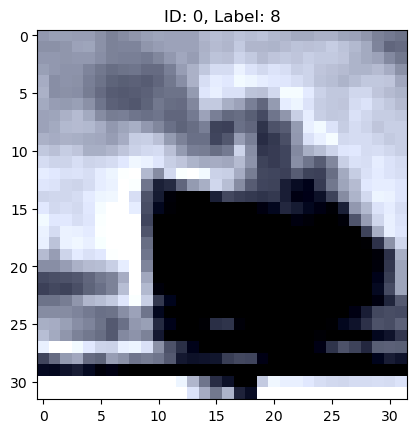

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


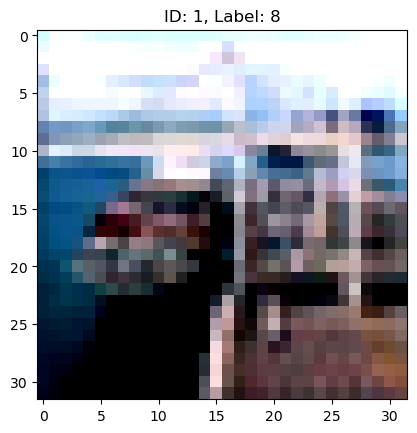

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


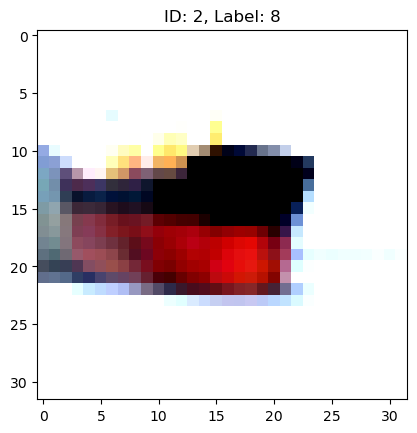

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


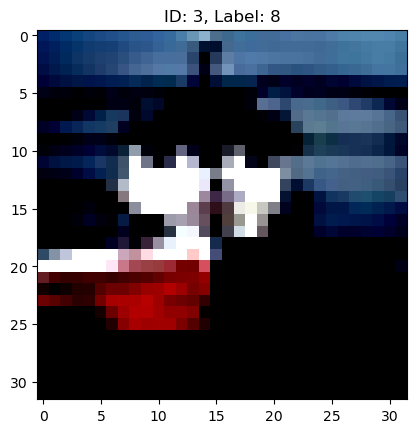

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


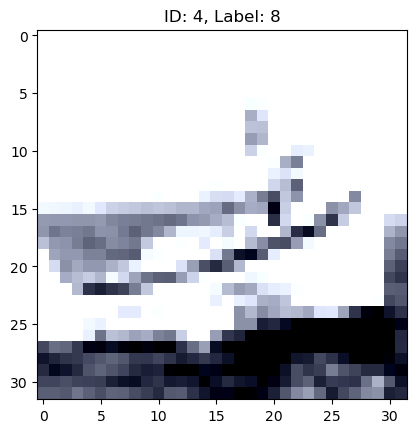

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


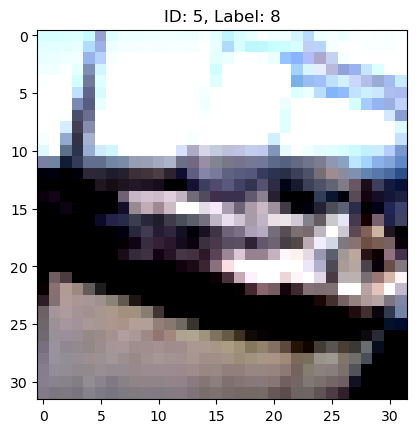

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


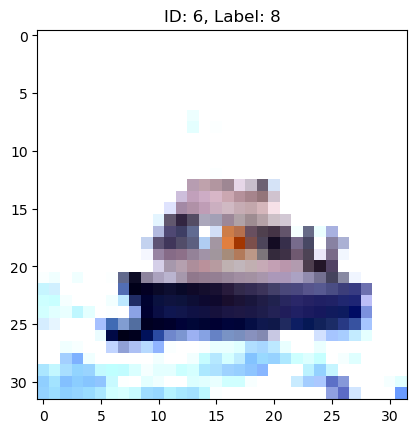

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


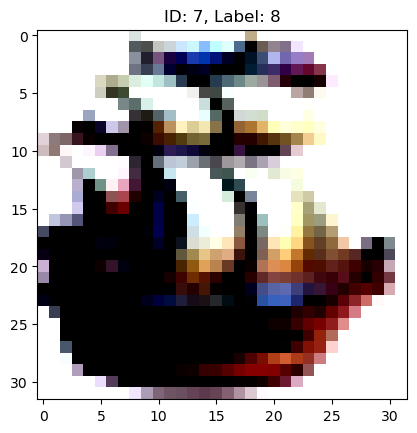

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


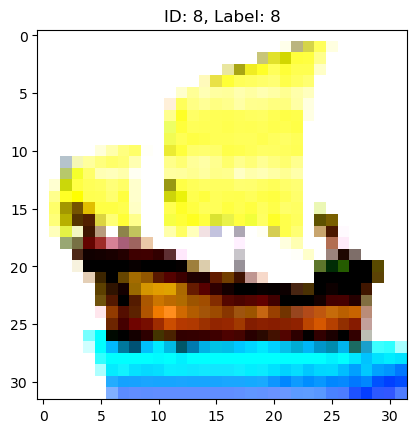

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


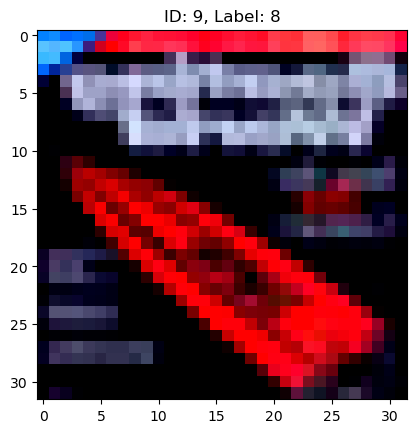

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


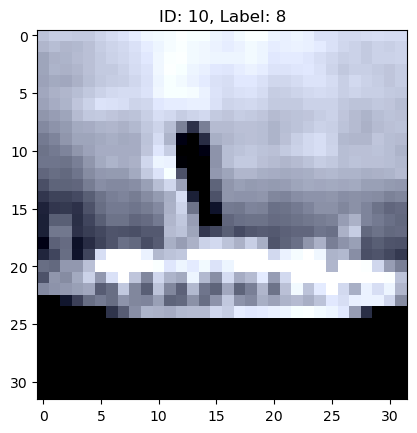

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


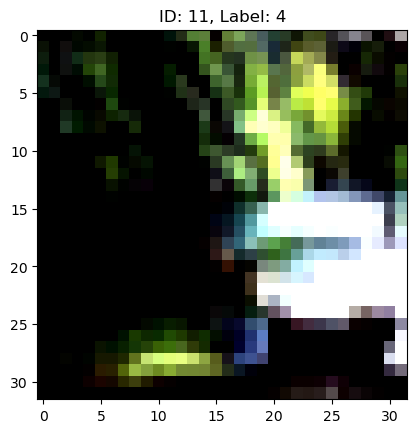

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


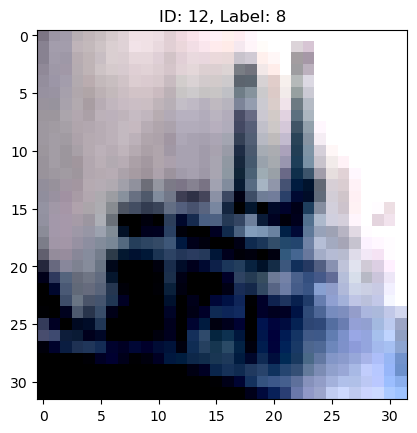

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


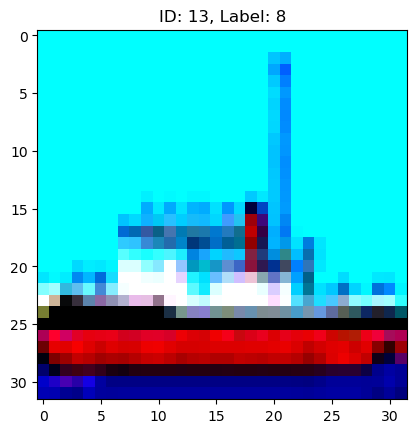

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


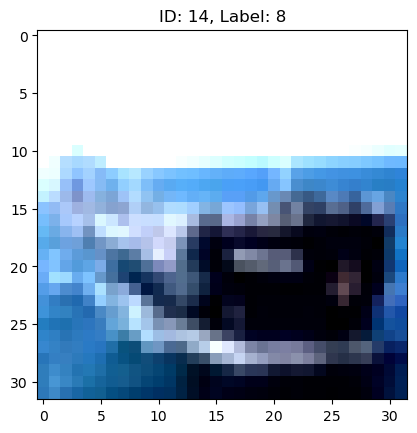

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


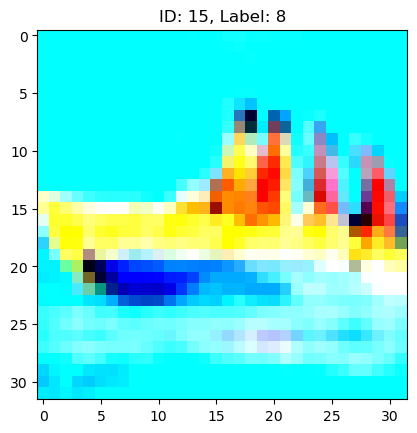

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


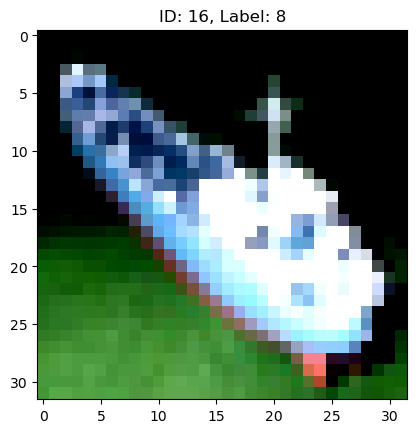

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


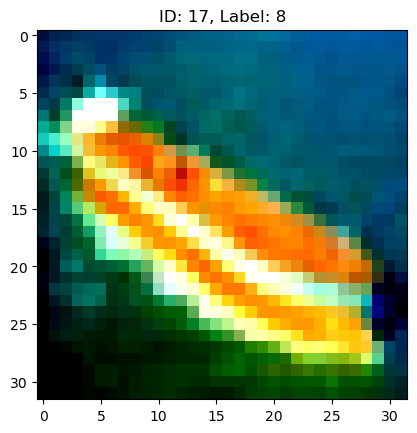

Done


In [18]:
import matplotlib.pyplot as plt
import pandas as pd

predictions = []

with torch.no_grad():
    # Initialize a counter to limit the number of displayed images
    display_limit = 18  # Set this to None to display all images
    displayed = 0
    
    for imgs, img_ids in unlabeled_loader:
        imgs = imgs.to(device)
        outputs = trainer.model(imgs)
        _, predicted_labels = torch.max(outputs, 1)
        for i in range(len(imgs)):
            img = imgs[i].cpu().numpy().transpose((1, 2, 0))
            img = (img * 0.5) + 0.5  # Unnormalize
            plt.imshow(img)
            plt.title(f'ID: {img_ids[i].item()}, Label: {predicted_labels[i].item()}')
            plt.show()
            
            displayed += 1
            if display_limit and displayed >= display_limit:
                break
        if display_limit and displayed >= display_limit:
            break
            predictions.extend(zip(img_ids.cpu().numpy(), predicted_labels.cpu().numpy()))

# Save predictions to CSV
df = pd.DataFrame(predictions, columns=['ID', 'Labels'])
df.to_csv('predictionsckptnnadadelta.csv', index=False)

print("Done")